In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
import h5py
from tqdm import tqdm
import pandas as pd
import sys, os
sys.path.append('../keras_network/')
sys.path.append('../data_processing/')
from data_generator import DataGenerator
from losses import metrics, all_metrics
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in all_metrics])
get_custom_objects().update(metrics_dict)
from preprocess_aqua import L_V, C_P, conversion_dict
import pickle
import pdb
import netCDF4 as nc
from glob import glob

In [33]:
model_dir = '/export/home/srasp/TF_models/'
model_fn = 'saved_keras_model_0220a.h5'
mean_fn = 'mean_nolat_0213.nc'
std_fn = 'std_nolat_0213.nc'

In [3]:
model_path = model_dir + model_fn
mean_path = model_dir + mean_fn
std_path = model_dir + std_fn

In [4]:
inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
outps = ['TPHYSTND_NORAD','PHQ']

In [5]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/'
aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
aqua_pattern = data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-0[1-5]-00000.nc'

In [72]:
class ModelDiagnostics(object):
    """
    Model diagnostics class.
    """
    def __init__(self, model_path, feature_vars, target_vars,
                 mean_path, std_path, valid_file_pattern, 
                 nlat=64, nlon=128, nlev=30):
        """
        TF version
        """
        self.model_path = model_path
        self.model = keras.models.load_model(model_path, custom_objects={"tf": tf})
        self.mean = nc.Dataset(mean_path, 'r')
        self.std = nc.Dataset(std_path, 'r')
        self.nlat = nlat; self.nlon = nlon; self.nlev = nlev
        self.ntime = 48
        self.ngeo = nlat * nlon
        self.feature_vars, self.target_vars = (feature_vars, target_vars)
        self.valid_files = sorted(glob(valid_file_pattern))

    def get_tp(self, var, idate, itime):
        """Return denormalized predictions and targets for one variable
        [lat, lon, lev]
        """
        # Get feature array
        f, t = self._get_ft(idate, itime)
        p = self._get_pred(f)
        var_idx = self.target_vars.index(var)
        t, p = (self.unravel(t), self.unravel(p))
        return self._denorm(t, 't')[:, :, var_idx], self._denorm(p, 't')[:, :, var_idx]
            
    def _get_f_or_t(self, idate, itime, f_or_t):
        with nc.Dataset(self.valid_files[idate], 'r') as ds:
            arr = []
            vars = self.feature_vars if f_or_t == 'f' else self.target_vars
            for var in vars:
                da = (ds[var][:] - self.mean[var][:]) / self.std[var][:]
                if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
                    a = np.rollaxis(da, 1, 4).reshape(-1, self.nlev)
                elif da.ndim == 3:   # 2D variables [time, lat, lon]
                    a = np.rollaxis(np.tile(da[itime].reshape(-1), (self.nlev, 1)), 0, 2)
                elif da.ndim == 1:   # lat
                    a = np.rollaxis(np.tile(da, (self.ntime, self.nlev, self.nlon, 1)), 
                                    1, 4).reshape(-1, 30)
                else:
                    raise Exception('Incompatible number of dimensions')
                arr.append(a)
            arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
        arr =  arr[:, :, -self.nlev:][:, ::-1]
        if itime is not None: arr = arr[itime*self.ngeo:(itime+1)*self.ngeo]
        return arr
    
    def _get_ft(self, idate, itime):
        return self._get_f_or_t(idate, itime, 'f'), self._get_f_or_t(idate, itime, 't')
    
    def _get_pred(self, f):
        return self.model.predict(f, batch_size=1024)
    
    def _denorm(self, x, f_or_t):
        for i, var in enumerate(self.feature_vars if f_or_t == 'f' else self.target_vars):
            m, s = [np.rollaxis(ds[var][-self.nlev:][::-1], 0, 3) 
                    for ds in [self.mean, self.std]]
            x[:, :, i, :] = x[:, :, i, :] * s + m
        return x
    
    def unravel(self, x):
        return x.reshape(self.nlat, self.nlon, -1, self.nlev)
    
    def compute_stats(self, niter=None):
        """
        Compute statistics over entire dataset [lat, lon, lev].
        bias = mean(preds) - mean(true)
        mse = sse(preds, true) / n_samples
        rel_mse = mse / std(true)
        std_error = std(preds) - std(true)
        """
        psum = np.zeros((self.ngeo, len(self.target_vars)*self.nlev))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        ndates = len(self.valid_files) if niter is None else niter
        n = ndates * self.ntime
        for idate in tqdm(range(ndates)):
            f_date, t_date = self._get_ft(idate, None)   # Full file
            for itime in range(self.ntime):
                f = f_date[itime*self.ngeo:(itime+1)*self.ngeo]
                t = t_date[itime*self.ngeo:(itime+1)*self.ngeo]
                # Get predictions
                p = self.model.predict_on_batch(f)  # [ngeo samples, z]
                # Unscale outputs at this level
                t, p = (self.unravel(t), self.unravel(p))
                t = self._denorm(t, 't')
                p = self._denorm(p, 't')
                t, p = [a.reshape(-1, len(self.target_vars)*self.nlev) for a in [t, p]]
                # Compute statistics
                psum += p; tsum += t
                psqsum += p ** 2; tsqsum += t ** 2
                sse += (t - p) ** 2


        # Compute average statistics
        self.stats_dict = {}
        pmean = psum / n; tmean = tsum / n
        self.bias = pmean - tmean; self.stats_dict['bias'] = self.bias
        self.mse = sse / n; self.stats_dict['mse'] = self.mse
        self.pred_var = (psqsum / n - pmean ** 2) * n / (n - 1)  # Sample variance
        self.stats_dict['pred_var'] = self.pred_var
        self.true_var = (tsqsum / n - tmean ** 2) * n / (n - 1)
        self.stats_dict['true_var'] = self.true_var
    
    def mean_stats(self, cutoff_level=9):
        expl_var_str = f'expl_var_cut{cutoff_level}'
        df = pd.DataFrame(
            index=self.target_vars + ['all'],
            columns=list(self.stats_dict.keys()) + [expl_var_str])
        # Compute statistics for each variable
        for var in self.target_vars + ['all']:
            sl = slice(0, None) if var == 'all' else \
                slice(self.target_vars.index(var), self.target_vars.index(var)+1, 1)
            for stat_name, stat in self.stats_dict.items():
                re_stat = self.unravel(stat)[:, :, sl]
                df.loc[var, stat_name] = np.mean(re_stat)

            df.loc[var, expl_var_str] = np.mean((1. - (
                 np.mean(self.unravel(self.mse)[:, :, sl], axis=(0, 1)) / 
                 np.mean(self.unravel(self.true_var)[:, :, sl], axis=(0, 1))
            ).reshape(-1, self.nlev))[:, :cutoff_level])
        return df

In [73]:
diag = ModelDiagnostics(model_path, inps, outps, mean_path, std_path, aqua_pattern)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [74]:
diag.compute_stats()

100%|██████████| 5/5 [01:08<00:00, 13.74s/it]


In [75]:
diag.mean_stats()

,bias,mse,pred_var,true_var,expl_var_cut9
TPHYSTND_NORAD,4.66984e-06,8.20865e-09,4.41419e-09,1.40964e-09,-2.67273e+09
PHQ,-5.50004e-09,8.14091e-14,1.07852e-14,6.82243e-14,-7.20305
all,2.33217e-06,4.10437e-09,2.2071e-09,7.04856e-10,-1.33636e+09


In [62]:
diag.mse[:, None].shape

(8192, 1, 60)

In [8]:
t, p = diag.get_tp('TPHYSTND_NORAD', 4, 47)

In [ ]:
diag.valid_files[4]

In [91]:
def plot_double_slice(t, p, var=None, unit='', **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    I1 = axes[0].imshow(t, **kwargs)
    I2 = axes[1].imshow(p, **kwargs)
    cb1 = fig.colorbar(I1, ax=axes[0], orientation='horizontal')
    cb2 = fig.colorbar(I2, ax=axes[1], orientation='horizontal')
    cb1.set_label(unit); cb2.set_label(unit)
    axes[0].set_title('SP-CAM Truth')
    axes[1].set_title('CBRAIN Predictions')
    plt.show()

In [92]:
range_dict = {
    'SPDT': [-5e-4, 5e-4],
    'SPDQ': [-5e-7, 5e-7],
    'QRL': [-2e-4, 2e-4],
    'QRS': [-1.2e-4, 1.2e-4],
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-5e-7, 5e-7],
}

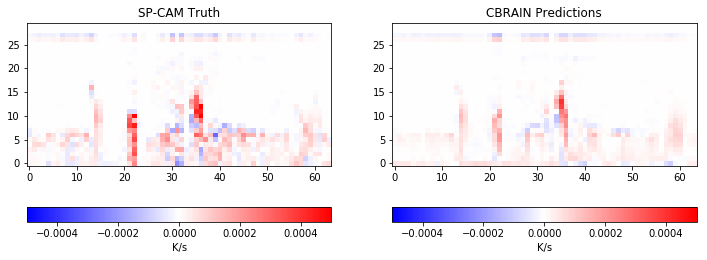

In [93]:
plot_double_slice(t[:, 0, :].T, p[:, 0, :].T, unit='K/s', cmap='bwr', 
                  vmin=-5e-4, vmax=5e-4, origin='lower')